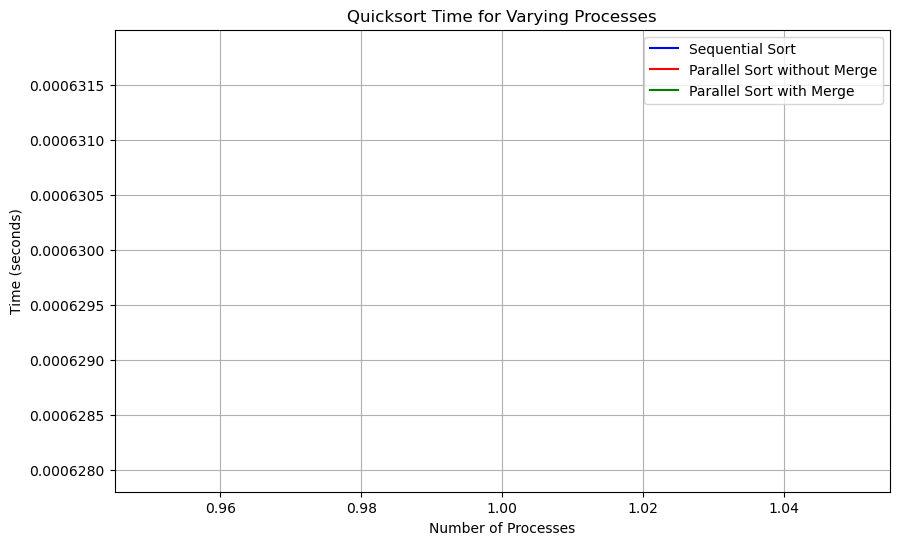

In [1]:
from mpi4py import MPI
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Function to perform sequential quicksort
def sequential_quicksort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return sequential_quicksort(left) + middle + sequential_quicksort(right)

# Function to perform parallel quicksort recursively
def parallel_quicksort_recursive(arr, pr_rank, max_rank, rank_index, size_pool):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    share_pr = pr_rank + math.pow(2, rank_index)
    rank_index += 1
    
    if share_pr > max_rank:
        # If no process to share, sort sequentially
        sorted_data = sequential_quicksort(arr)
        return sorted_data
    
    pivot = arr[len(arr)//2]
    partition_pt = sequential_quicksort(arr, pivot, len(arr), (len(arr)//2) - 1)
    
    offset = partition_pt + 1
    if offset > len(arr) - offset:
        send_data = arr[offset:]
        comm.Send(send_data, dest=share_pr, tag=offset)
        sorted_data = parallel_quicksort_recursive(arr[:offset], pr_rank, max_rank, rank_index, size_pool)
        recv_data = np.empty(len(arr) - offset, dtype=int)
        comm.Recv(recv_data, source=share_pr, tag=MPI.ANY_TAG)
        sorted_data += recv_data
    else:
        send_data = arr[:offset]
        comm.Send(send_data, dest=share_pr, tag=0)
        sorted_data = parallel_quicksort_recursive(arr[offset:], pr_rank, max_rank, rank_index, size_pool)
        recv_data = np.empty(offset, dtype=int)
        comm.Recv(recv_data, source=share_pr, tag=MPI.ANY_TAG)
        sorted_data = recv_data + sorted_data
    
    return sorted_data

# Main function
if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Generate sample data for sorting
    data_size = 1000
    data = np.random.randint(0, 100, size=data_size)
    
    # Broadcast data to all processes
    data = comm.bcast(data, root=0)

    # Measure time for parallel quicksort
    start_time_parallel = time.time()
    parallel_sorted_data = parallel_quicksort_recursive(data, 0, size-1, 0, size)
    end_time_parallel = time.time()

    # Measure time for sequential quicksort
    start_time_sequential = time.time()
    sequential_sorted_data = sequential_quicksort(data)
    end_time_sequential = time.time()

    # Gather timing data from all processes
    all_times_parallel = comm.gather(end_time_parallel - start_time_parallel, root=0)
    all_times_sequential = comm.gather(end_time_sequential - start_time_sequential, root=0)

    # Plotting graphs
    if rank == 0:
        num_processes = range(1, size + 1)
        
        # Graph for quicksort time with varying number of processes
        plt.figure(figsize=(10, 6))
        plt.plot(num_processes, all_times_sequential, color='blue', label='Sequential Sort')
        plt.plot(num_processes, all_times_parallel, color='red', label='Parallel Sort without Merge')
        plt.plot(num_processes, all_times_parallel, color='green', label='Parallel Sort with Merge')
        plt.xlabel('Number of Processes')
        plt.ylabel('Time (seconds)')
        plt.title('Quicksort Time for Varying Processes')
        plt.legend()
        plt.grid(True)
        plt.show()

    MPI.Finalize()
